<a href="https://colab.research.google.com/github/suptechlab/Data-Gymnasium/blob/main/notebooks/M2_1_Complaints_handling_and_triage_using_supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

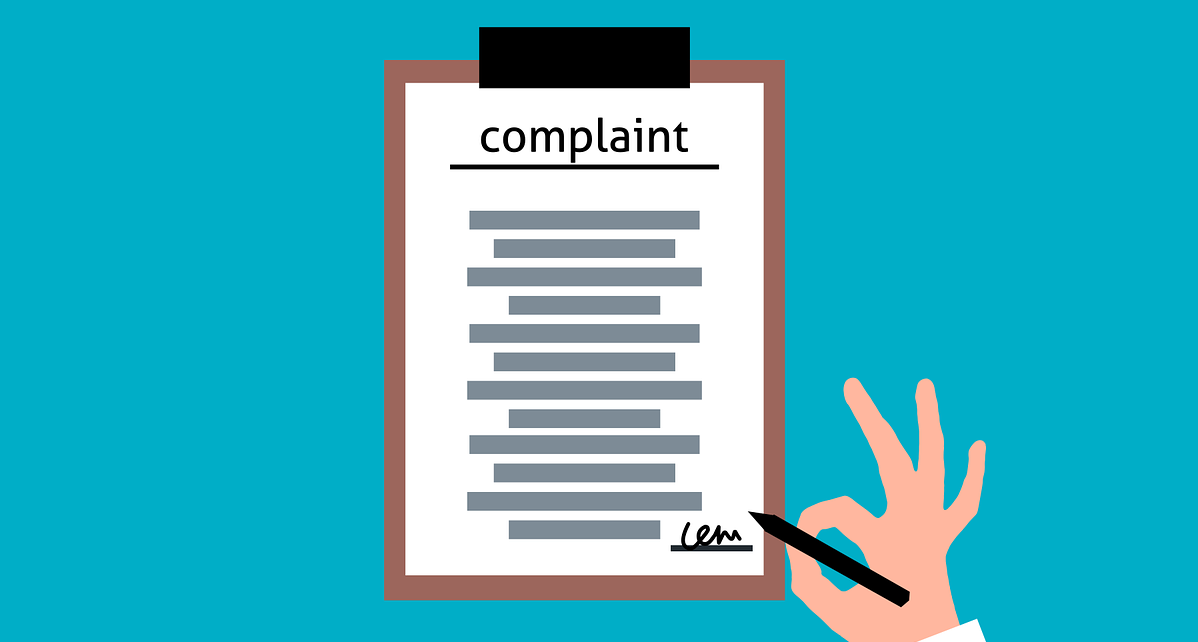


# Consumer Complaints Text Classification and Prediction (Multiclass)

## Disclaimer

-----------------------------------------------------------------------------------------
**This data science notebook is provided for educational purposes only.**

It contains code, analysis, and models that are intended to serve as learning materials and examples. The content is not intended for direct deployment to production environments.

You are encouraged to adapt and modify the contents of this notebook in accordance with the license provided in the associated github repository. However, it is essential to exercise caution, further development, and thorough testing before considering any deployment to production systems.

The authors and contributors of this notebook assume no liability for any consequences, including financial or operational, resulting from the use or misuse of the information and code provided herein. Always consult with appropriate experts and conduct rigorous testing and validation before applying any techniques or models in a real-world, production context.

**By using this notebook, you agree to these terms and conditions.**

-----------------------------------------------------------------------------------------


## Content

Consumer complaints received about financial products and services, these are real world complaints received about financial products and services. Each complaint has been labeled with a specific product; therefore, this is a supervised text classification problem. With the aim to classify future complaints based on its content, we used different machine learning algorithms can make more accurate predictions (i.e., classify the complaint in one of the product categories).

## Resources and Acknowledgements

Notebook adapted from: https://eu-gb.dataplatform.cloud.ibm.com/analytics/notebooks/v2/eb624a2a-edd1-4971-8a66-3c67c6f1d8c9/view?access_token=f81b54fdcf1cfcb574b4a1c29ddfc20f56bc342477a405e59b38587a506d177e

New public dataset downloaded from https://www.consumerfinance.gov/data-research/consumer-complaints/

## Our Target:

Classify consumer complaints into predefined categories.

Classification algorithms: Linear Support Vector Machine (LinearSVM) and Multinomial Naive Bayes .

Note: Text classification is an example of supervised machine learning since we train the model with labelled data.

## Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import gc

## Reading the data

In [2]:
# pandas now supports ability to read straight from zipped csv
df = pd.read_csv("https://files.consumerfinance.gov/ccdb/complaints.csv.zip") # Warning! 589.1 MB file, will take ~1min to load
df.shape

<ipython-input-2-e1840c0d2c9d>:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://files.consumerfinance.gov/ccdb/complaints.csv.zip") # Warning! 589.1 MB file, will take ~1min to load


(4118869, 18)

## Cleaning the data
In our complaints dataset, we have over 4.1 million observations (rows), each with 18 featuers (columns)

In [3]:
df.head(2).T

,0,1
Date received,2023-08-14,2023-08-23
Product,Debt collection,"Credit reporting, credit repair services, or o..."
Sub-product,Credit card debt,Credit reporting
Issue,Attempts to collect debt not owed,Problem with a credit reporting company's inve...
Sub-issue,Debt is not yours,Investigation took more than 30 days
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,SYNCHRONY FINANCIAL,"EQUIFAX, INC."
State,CA,TN
ZIP code,92311,38116


The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem, we are going to build another dataframe that contains `Product` and `Consumer complaint narrative` (which we'll rename to `Complaint`).

In [4]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Complaint']

df1.shape

(1493344, 2)

In [5]:
total = df1['Complaint'].notnull().sum()
round((total/len(df)*100),1)

36.3

Of the original 4.1+ million observations, we are left with just under 1.5 million (36.3%) that have an actual complaint body populated.

In [6]:
# Data cleaning
# Note: because we have limited RAM on free tier, we'll want to clean up variables we're no longer using
# In a real-world data science setup, we'd likely want to keep these around in case we need to go back to them for further experimentation
del df
gc.collect()

0

In [7]:
df1.head(15)

,Product,Complaint
14,"Credit reporting, credit repair services, or o...",To whom It may concern : I recently received a...
17,"Credit reporting, credit repair services, or o...",I submitted a letter to the XXXX Credit Bureau...
22,"Credit reporting, credit repair services, or o...",EXPERIAN an XXXX I XXXX XXXX XXXX recently rev...
34,"Credit reporting, credit repair services, or o...",In accordance with the Fair Credit Reporting a...
224,Credit reporting or other personal consumer re...,The company did not explain the computer error...
251,"Credit reporting, credit repair services, or o...","XX/XX/ XXXX XXXX XXXX XXXX XXXX XXXX, Fl XXXX ..."
252,Checking or savings account,"In XXXX of 2022, a check in the amount of {$15..."
264,Checking or savings account,Information came to my attention that all my a...
713,"Credit reporting, credit repair services, or o...","I sent a letter out on XX/XX/XXXX to XXXX, XXX..."
814,Credit card,This card charges an APR over 30 percent in ad...


In [8]:
pd.DataFrame(df1.Product.unique()).values

array([['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Credit reporting or other personal consumer reports'],
       ['Checking or savings account'],
       ['Credit card'],
       ['Money transfer, virtual currency, or money service'],
       ['Debt collection'],
       ['Mortgage'],
       ['Student loan'],
       ['Vehicle loan or lease'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Credit card or prepaid card'],
       ['Prepaid card'],
       ['Payday loan, title loan, or personal loan'],
       ['Debt or credit management'],
       ['Money transfers'],
       ['Credit reporting'],
       ['Bank account or service'],
       ['Consumer Loan'],
       ['Payday loan'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

In [9]:
len(df1.Product.unique())

21

There are 21 different classes or categories (i.e., the target our model will predict). However; it is observed that some classes are contained in others. For instance, `Credit card` and `Prepaid card` are contained in `Credit card or prepaid card` category. Now, imagine there is a new complaint about Credit card and we want to classify it. The algorithm can either classify this complaint as `Credit card` or `Credit card or prepaid` and it would be correct. Nevertheless, this would affect model performance. In order to avoid this problem, the names of some categories should be renamed.

In [10]:
# Renaming categories
df2 = df1.replace({
    'Product':
      {
        'Credit reporting': 'Credit reporting, repair, or other',
        'Credit reporting or other personal consumer reports': 'Credit reporting, repair, or other',
        'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting, repair, or other',
        'Credit card': 'Credit card or prepaid card',
        'Prepaid card': 'Credit card or prepaid card',
        'Payday loan': 'Payday loan, title loan, personal loan, or advance loan',
        'Payday loan, title loan, or personal loan': 'Payday loan, title loan, personal loan, or advance loan',
        'Money transfers': 'Money transfer, virtual currency, or money service',
        'Virtual currency': 'Money transfer, virtual currency, or money service'
      }
    },
    inplace = False) # if this was a MASSIVE dataset, you may not want to make a copy but rather use df1 and inplace = True

In [21]:
# Note: because we have limited RAM on free tier, we'll want to clean up variables we're no longer using
# In a real-world data science setup, we'd likely want to keep these around in case we need to go back to them for further experimentation
del df1
gc.collect()

59

In [11]:
df2.groupby('Product').count()

,Complaint
Product,
Bank account or service,14885
Checking or savings account,77115
Consumer Loan,9461
Credit card or prepaid card,127273
"Credit reporting, repair, or other",819894
Debt collection,220173
Debt or credit management,10
"Money transfer, virtual currency, or money service",35027
Mortgage,108697


Note there are only 10 complaints of 1.5 MILLION that are classified as `Debt or credit management`, so we will combine them with `Other financial service`.

In [12]:
df2.replace({
    'Product':
      {
        'Debt or credit management': 'Other financial service'
      }
    },
    inplace = True)

In [13]:
len(df2.Product.unique())

12

A few observations:

* The number of classes were reduced from 21 to 12.
* Now we need to represent each class as a number, so as our predictive model can better understand the different categories.



In [14]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head(10)

,Product,Complaint,category_id
14,"Credit reporting, repair, or other",To whom It may concern : I recently received a...,0
17,"Credit reporting, repair, or other",I submitted a letter to the XXXX Credit Bureau...,0
22,"Credit reporting, repair, or other",EXPERIAN an XXXX I XXXX XXXX XXXX recently rev...,0
34,"Credit reporting, repair, or other",In accordance with the Fair Credit Reporting a...,0
224,"Credit reporting, repair, or other",The company did not explain the computer error...,0
251,"Credit reporting, repair, or other","XX/XX/ XXXX XXXX XXXX XXXX XXXX XXXX, Fl XXXX ...",0
252,Checking or savings account,"In XXXX of 2022, a check in the amount of {$15...",1
264,Checking or savings account,Information came to my attention that all my a...,1
713,"Credit reporting, repair, or other","I sent a letter out on XX/XX/XXXX to XXXX, XXX...",0
814,Credit card or prepaid card,This card charges an APR over 30 percent in ad...,2


The bar chart below shows the number of complaints per category. It can be observed that The bar chart below shows the number of complaints per category. It can be observed that most of customer complaints are due to:

* credit reporting, credit repair, or other credit related issues
* debt collection
* mortgage

Note: in a real life scenario, we may want to take note that the first category represents a significantly higher magnitude than the others, and could be disaggregated (e.g., into credit reporting, credit repair, and other).

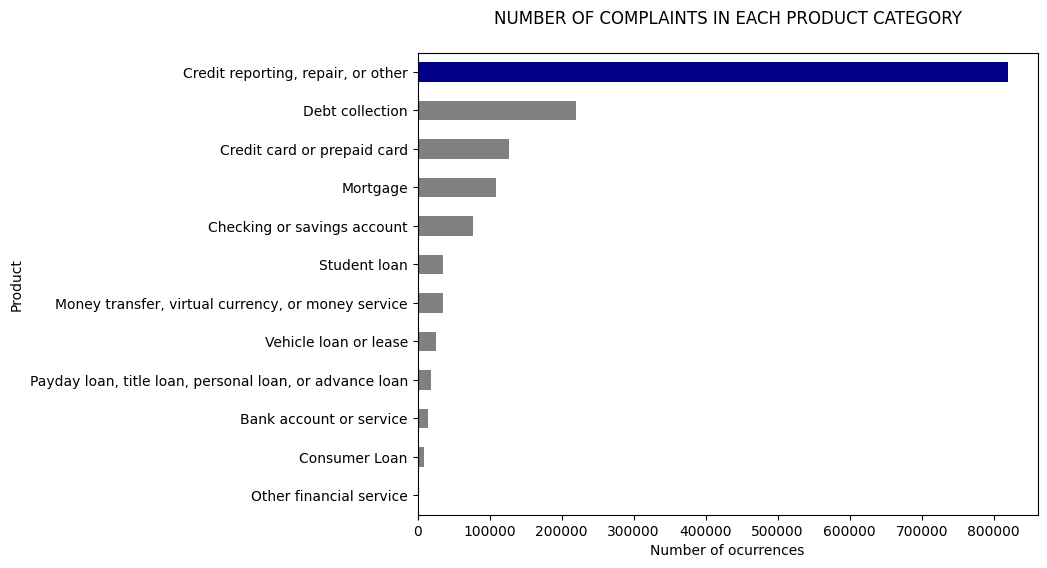

In [15]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

## Text Preprocessing

The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency - Inverse Document Frequency (TFIDF) weight to evaluate how important a word is to a document in a collection of documents.

After removing punctuation and lower casing the words, importance of a word is determined in terms of its frequency.




### TF-IDF Primer

Term Frequency – Inverse Document Frequency
TF - IDF is the product of the TF and IDF scores of the term.
TF - IDF = TF / IDF

Term Frequency : This summarizes how often a given word appears within a document.

TF = Number of times the term appears in the docTotal number of words in the doc

Inverse Document Frequency: This downscales words that appear a lot across "documents" (i.e., our complaints observations in this case). A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.

IDF = ln (Number of docsNumber docs the term appears in)

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word mortgage would be mentioned fairly often. However, if we look at other complaints, mortgage probably would not show up in many of them. We can infer that mortgage is most probably an important word in Mortgage complaints as compared to the other products. Therefore, mortgage would have a high TF-IDF score for Mortgage complaints.

`TfidfVectorizer` class can be initialized with the following parameters:

* `min_df`: remove the words from the vocabulary which have occurred in less than `min_df` number of files.
* `max_df`: remove the words from the vocabulary which have occurred in more than _`maxdf` * total number of files in corpus.
* `sublinear_tf`: set to True to scale the term frequency in logarithmic scale.
* `stop_words`: remove the predefined stop words in 'english'.
* `use_idf`: weight factor must use inverse document frequency.
* `ngram_range`: (1, 2) to indicate that unigrams and bigrams will be considered.

So we begin by transforming each complaint into a vector.

In [16]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# WARNING!!! If we use the full dataset of ~1.5 million observations, the following line of code will crash the runtime (RAM resources) on Colab's free tier.
# One option would be to pay for a premium account, and go grab a coffee while this crunches for ~30min
# Because the computation is also time consuming (in terms of CPU), the data was sampled to 15,000 which is sufficient to create a model

df2 = df2.sample(15000, random_state=1337).copy()

features = tfidf.fit_transform(df2.Complaint).toarray() # Note: this will take ~5sec

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 15000 complaints is represented by 36612 features (TF-IDF score of unigrams and bigrams)


Finding the three most correlated terms with each of the product categories

In [17]:
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Bank account or service:
  * Most Correlated Unigrams are: bank, overdraft, citigold
  * Most Correlated Bigrams are: account overdraft, citigold checking, bonus account

==> Checking or savings account:
  * Most Correlated Unigrams are: checking, overdraft, bank
  * Most Correlated Bigrams are: overdraft fee, savings account, checking account

==> Consumer Loan:
  * Most Correlated Unigrams are: car, chrysler, drivetime
  * Most Correlated Bigrams are: payment way, credit purchase, chrysler capital

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: citi, express, card
  * Most Correlated Bigrams are: card company, american express, credit card

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: 1681, section, reporting
  * Most Correlated Bigrams are: reporting agency, 15 1681, 1681 section

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: collection agency, debt collector, co

Pretty cool! We already see that natural language processing has given us some key words that can indicate a category purely off the raw text.

## Building our model


We'll now evaluate two multi-classification models:

* Linear Support Vector Machine
* Multinomial Naive Bayes



### Splitting the data (train vs test)

Here we will:
1. divide the original data into features (X) and target (y),
2. split into train (75%) and test (25%) sets

Thus, the algorithms will be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [18]:
X = df2['Complaint'] # Collection of "documents" (observations of complaints)
y = df2['Product'] # Target or the labels we want to predict (i.e., the 14 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

In [19]:
models = [LinearSVC(), MultinomialNB(),]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [20]:
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV) # Note: this line takes around 60 seconds
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

## Comparison of models' performance

In [21]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()
acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.836533,0.005956
MultinomialNB,0.704800,0.003388


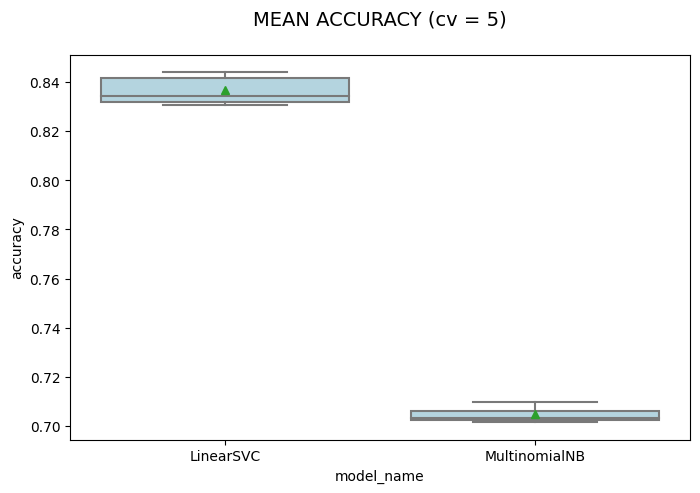

In [22]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

## Model evaluation

In [23]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features,
                                                               labels,
                                                               df2.index, test_size=0.25,
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Precision, recall, F1 score

In [24]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                                         precision    recall  f1-score   support

                     Credit reporting, repair, or other       0.89      0.95      0.92      2129
                                        Debt collection       0.61      0.72      0.66       174
                                           Student loan       0.73      0.71      0.72       304
                            Credit card or prepaid card       0.87      0.65      0.74        83
                                               Mortgage       0.78      0.74      0.76       531
                            Checking or savings account       0.86      0.91      0.88       258
                                  Vehicle loan or lease       0.87      0.74      0.80       105
     Money transfer, virtual currency, or money service       0.60      0.47      0.52        58
                                Bank account or service       0.33      0.08      0.13        36


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We observe that the classes with more support (number of occurrences) tend to have a better f1-score.

This is because the algorithm was trained with more data. In a real-world scenario we could increase our sample size to provide more support for these data points.

The classes that can be classified with most precision are `Credit reporting, repair, or other`, `Vehicle loan or lease`, and `Credit card or prepaid card`, and `Checking or savings account`.


### Confusion Matrix

A Confusion Matrix is a table which rows represent the actual class and columns represents the predicted class.

If we had a perfect model that always classifies correctly a new complaint, then the confusion matrix would have values in the diagonal only (where predicted label = actual label).


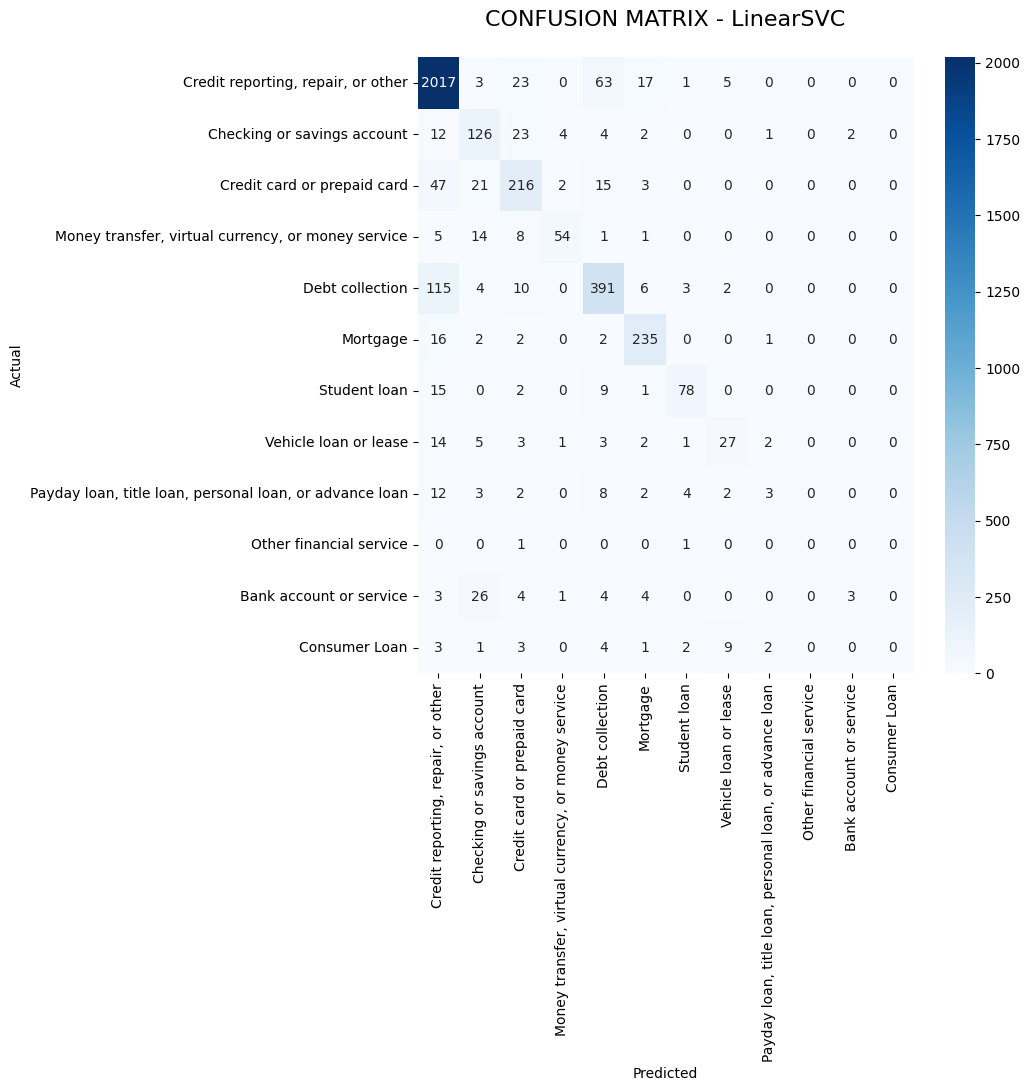

In [25]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In general, the confusion matrix looks good (clear diagonal that represents correct classifications). Nevertheless, there are cases were the complaint was classified in a wrong class.

## Inspection of misclassifications

Let’s have a look at the cases that were wrongly classified.

In [27]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat[actual, predicted]))

      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product',
                                                                'Complaint']])
      print('')

'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 47 examples.


,Product,Complaint
2594425,Credit card or prepaid card,I 'm writing in regards to Navy Federal Credit...
2447545,Credit card or prepaid card,"BB & T sent me a letter saying I have "" delinq..."
976639,Credit card or prepaid card,"Hello, Someone has opened a credit card using ..."
1020682,Credit card or prepaid card,I have a loan with CBNA. I have always made my...
2078847,Credit card or prepaid card,needs to be removed from my credit report please
236556,Credit card or prepaid card,I discovered fraudulent activity on this accou...
1720115,Credit card or prepaid card,I was charged XXXX someone has been using my a...
1523232,Credit card or prepaid card,"I sponsored a credit card for my son, XXXX XXX..."
3639015,Credit card or prepaid card,Every month capital One report to every credit...
254534,Credit card or prepaid card,XXXX has been non-compliant with removing the ...



'Debt collection' predicted as 'Credit reporting, repair, or other' : 115 examples.


,Product,Complaint
1948607,Debt collection,I am a victim of identity theft. Please delete...
744748,Debt collection,On XX/XX/XXXX Central States Recovery reported...
1250191,Debt collection,A creditor on my consumer credit report sold m...
203556,Debt collection,I first discovered this account on my credit r...
599759,Debt collection,This account is reflecting on my credit report...
...,...,...
1148578,Debt collection,"My name is XXXX XXXX, a federally protected co..."
1936036,Debt collection,This debit collector does n't have my name cor...
1031483,Debt collection,Contacted the company and credit bureaus regar...
3947586,Debt collection,I pulled my credit report and found all these ...



'Credit card or prepaid card' predicted as 'Checking or savings account' : 21 examples.


,Product,Complaint
3036225,Credit card or prepaid card,I sent a deposit in XX/XX/XXXX to a vendor for...
1613472,Credit card or prepaid card,"On XX/XX/2022, I filed a dispute with Chime du..."
270533,Credit card or prepaid card,XX/XX/XXXX - There was a fraudulent charge on ...
1610259,Credit card or prepaid card,They closed the account with out our authoriza...
3371267,Credit card or prepaid card,Keybank is withholding my funds ( {$3000.00} )...
3880443,Credit card or prepaid card,Company will not verify in writing if account ...
1229566,Credit card or prepaid card,"ATTN : PPD Dispute, KEY BANK Dispute XXXX ( I ..."
1456830,Credit card or prepaid card,XX/XX/2022 my card was used in Florida at a co...
394112,Credit card or prepaid card,Hi my name is XXXX XXXX I'm a victim of fraud....
1202446,Credit card or prepaid card,I called my KeyBank unemployment benefits bank...



'Bank account or service' predicted as 'Checking or savings account' : 26 examples.


,Product,Complaint
1651334,Bank account or service,Our company runs a XXXX to help low income com...
3028763,Bank account or service,SunTrust has repeatedly opened new checking ac...
1783625,Bank account or service,I deposit appoximately XXXX in order to cover ...
1502608,Bank account or service,I opened a Bank of America core checking accou...
3090955,Bank account or service,I have a bank account with Ally my wife takes ...
1462242,Bank account or service,"I lost my bank account card one day, and did n..."
3618252,Bank account or service,I opened a keybank bank account with the confi...
3147849,Bank account or service,Wachovia closed my checking account and issued...
2295554,Bank account or service,"On XXXX XXXX, 2016 I made a {$100.00} ATM debi..."
1565881,Bank account or service,I deposited a check at Bank of America on XXXX...



'Credit reporting, repair, or other' predicted as 'Credit card or prepaid card' : 23 examples.


,Product,Complaint
3867918,"Credit reporting, repair, or other",I lost my social security card and they try to...
294405,"Credit reporting, repair, or other","Dear Sir, I have closed my individual chase cr..."
2881745,"Credit reporting, repair, or other",I closed my {$500.00} limit credit card accoun...
713194,"Credit reporting, repair, or other",MACY 's has reported a result of miscommunicat...
2696308,"Credit reporting, repair, or other",I had not used my XXXX credit card in a long t...
1044114,"Credit reporting, repair, or other",My name is XXXX XXXX : my account number is XX...
268128,"Credit reporting, repair, or other",I have called XXXX XXXX XXXX about my issues ...
4019517,"Credit reporting, repair, or other",I had a credit card with TD Bank USA / Target ...
2064912,"Credit reporting, repair, or other","XXXX account XXXX, XXXX credit card account en..."
984452,"Credit reporting, repair, or other",This particular account situation that is late...



'Checking or savings account' predicted as 'Credit card or prepaid card' : 23 examples.


,Product,Complaint
3148151,Checking or savings account,My debit card was fraudulently used XX/XX/XXXX...
2042690,Checking or savings account,"On XX/XX/2019, I realized three large transact..."
774706,Checking or savings account,On XX/XX/XXXX two ATM withdrawals took place i...
1776389,Checking or savings account,I called about an unauthorized charge. I was t...
1698805,Checking or savings account,This was in like 2016 and my card kept overdra...
2932985,Checking or savings account,REF # : XXXX In regards to FRAUD on Chase acco...
2428889,Checking or savings account,This is a second complaint to the initial one ...
3063717,Checking or savings account,"Hi, I tried to purchase an XXXX laptop at the ..."
2390244,Checking or savings account,I spoke with JP Morgan Chase Bank on Tuesday X...
2573831,Checking or savings account,"On XX/XX/2023, I paid for a room at the XXXX X..."



'Credit reporting, repair, or other' predicted as 'Debt collection' : 63 examples.


,Product,Complaint
1084702,"Credit reporting, repair, or other","In an attempt to collect an invalidated debt, ..."
1023857,"Credit reporting, repair, or other",In 2013 I open a card with Continental Finance...
3963145,"Credit reporting, repair, or other",During the height of the pandemic in XXXX of 2...
681437,"Credit reporting, repair, or other",Account Number : XXXX Original Creditor : XXXX...
383832,"Credit reporting, repair, or other",I am being charged over 300 $ from something c...
...,...,...
2782060,"Credit reporting, repair, or other",there is an account on my credit report for a ...
2017565,"Credit reporting, repair, or other",XXXX XXXX XXXX contacted me after I sent them ...
728797,"Credit reporting, repair, or other",Waypoint Resource Group allegedly bought a deb...
462441,"Credit reporting, repair, or other",I XXXX XXXX XXXX entered into a consumer credi...


### Most correlated terms with each category

In [29]:
N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Bank account or service':
  * Top unigrams: bank, debit, gold, wo
  * Top bigrams: refuse return, letter came, key bank, check xxxx

==> 'Checking or savings account':
  * Top unigrams: bank, chime, account, savings
  * Top bigrams: debit card, checking account, overdraft fee, consumer transaction

==> 'Consumer Loan':
  * Top unigrams: drivetime, loan, financed, delinquencies
  * Top bigrams: credit purchase, payment told, payment way, chrysler capital

==> 'Credit card or prepaid card':
  * Top unigrams: card, synchrony, cards, citi
  * Top bigrams: received money, late fee, balance transfer, american express

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, experian, transunion, report
  * Top bigrams: xxxx xxxx, credit company, xxxx reported, xxxx opened

==> 'Debt collection':
  * Top unigrams: debt, collection, collect, recovery
  * Top bigrams: want removed, account fraudulent, violation knowledge, trying collect

==> 'Money transfer, virtual currency, 

## Predictions

Now let's make predictions against unseen data

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [31]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


The algorithm has classified this text as a "Student loan" complaint. Makes sense!

Now let's check another complaint.

In [34]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']


It appears our model is doing well for just an hour's worth of work!

Of course, there are many nuances that must be accounted for in real-world scenarios, including:

* Multilingual complaints (this set is only english)
* Messy or inconsistent labeling (this set is already cleaned by CFPB before publishing)
* Completely missing labels (in an authority where consumer complaints are not yet digital, labeled datasets needed to train the model can break)